In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import re

In [3]:
from python_nn.models import Sequential
from python_nn.layers.dense import Dense
from python_nn.callbacks import Monitor
from python_nn.layers.convolution import ConvLayer1D

In [4]:
def val2onehot(val_array, classes):
    labels = np.zeros((len(val_array), classes))
    for ind,lbl in enumerate(val_array):
        labels[ind,lbl] = 1
    return labels

name_dir = 'CNN_data/ascii_names.txt'
labels_dir = 'CNN_data/category_labels.txt'
regex_names = re.compile(r'(.+) ([0-9]+)')
regex_labels = re.compile(r'([0-9]+) (.+)')
name_dict = {}
labels_dict = {}
with open(name_dir, 'r') as r_file:
    for line in r_file:
        name = regex_names.match(line).group(1).lower()
        number = regex_names.match(line).group(2)
        name_dict[name] = int(number)
with open(labels_dir, 'r') as r_file:
    for line in r_file:
        number = regex_labels.match(line).group(1)
        name = regex_labels.match(line).group(2)
        labels_dict[number] = name

# building the matrices

num_of_classes = max(name_dict.values())
max_len = 0
char_dict = {}
for name in name_dict.keys():
    if max_len < len(name):
        max_len = len(name)
    for char in name:
        if char not in char_dict.keys():
            char_dict[char] = len(char_dict)
dif_chars = len(char_dict)
input_array = np.zeros((len(name_dict), dif_chars, max_len))
labels_array = np.zeros((len(name_dict), 1), dtype=int)
for i, name in enumerate(name_dict.keys()):
    labels_array[i] = name_dict[name]
    for j, char in enumerate(name):
        input_array[i, char_dict[char], j] = 1
input_array_flatten = np.zeros((len(name_dict), dif_chars* max_len), dtype=int)
for i in range(input_array.shape[0]):
    input_array_flatten[i] = input_array[i].flatten('F')
labels_array -= 1

freqdict = np.unique(labels_array, return_counts=True)
l = np.sum(freqdict[1])/ freqdict[1]/18
labels = val2onehot(labels_array, 18)
validation = int(input_array_flatten.shape[0]*0.2)
rnd_choice = np.random.choice(input_array_flatten.shape[0],validation)
validation_ind = np.zeros((input_array_flatten.shape[0]))
validation_ind[rnd_choice] = 1
validation_set = input_array_flatten[validation_ind == 1]
training_set = input_array_flatten[validation_ind == 0]
validation_labels = labels[validation_ind == 1]
validation_labels_ind = labels_array[validation_ind == 1]
training_labels = labels[validation_ind == 0]

In [9]:
newNN = Sequential(dim_2d=(dif_chars,max_len))
newNN.add_layer(ConvLayer1D, filter_len=5, filter_num=20, function='relu', padding=0, stride=1)
newNN.add_layer(ConvLayer1D, filter_len=3, filter_num=20, function='relu', padding=0, stride=1)
newNN.add_layer(Dense, nodes=18, function='softmax')

In [10]:
newNN.compile(loss_func='entropy', loss_weights=l, regularizer={'name': 'ridge', 'args': {'lamb': 0}})

In [7]:
monitor = Monitor(validation_set, validation_labels)

In [11]:
#new_model.monitor('val', inputs_2, labels_2)
newNN.train(training_set, training_labels, 60, 32, callbacks=[monitor])

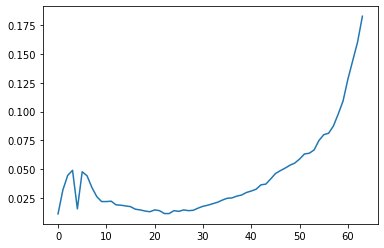

In [12]:
res = monitor.pandas()
plt.plot(res['accuracy'])

In [19]:
res

,epoch,iteration,accuracy,loss,total loss
0,0.0,0.0,0.004412,2.929205,2.929205
1,1.0,446.0,0.005358,2.841411,2.841411
2,2.0,892.0,0.004412,2.835437,2.835437
3,3.0,1338.0,0.003467,2.835158,2.835158
4,0.0,0.0,0.003152,2.832788,2.832788
...,...,...,...,...,...
79,35.0,15610.0,0.203908,2.472572,2.472572
80,36.0,16056.0,0.208320,2.500458,2.500458
81,37.0,16502.0,0.208005,2.530741,2.530741
82,38.0,16948.0,0.209896,2.566993,2.566993


In [20]:
3%np.inf

3.0

In [48]:
monitor.clear()